# 3: Analyse Results and Visualize Predictions

* Time to run the cells: ~ 5 mins

First thing's first; set the absolute path of the ``rho_learn`` directory on
your local machine, for instance:

``RHOLEARN_DIR = "/Users/joe.abbott/Documents/phd/code/qml/rho_learn/"``

In this notebook we will plot a few analysis plots using data outputted from the
model training procedure. 

Then we will load our validation structure, make a prediction on it, and
visualize the predicted, target, and delta electron densities.

In [1]:
import os
import ase.io
import matplotlib.pyplot as plt
import numpy as np

import equistore
import qstack

import rholearn.io
from rholearn import analysis, io, plots, utils
from settings import RASCAL_HYPERS, DATA_SETTINGS, ML_SETTINGS

In [2]:
# Create directory to save plots and visualizations
plot_dir = os.path.join(ML_SETTINGS["run_dir"], "plots")
rholearn.io.check_or_create_dir(plot_dir)

## Training Analysis

Based on the learning exercise run in the previous notebook, we can produce some
analysis plots.

First, plot a log-log figure of the train and test losses against epoch.

In [3]:
# Define the range of exercises and subsets to compile data for
exercises = [0]
subsets = [0, 1, 2]

# Compile data
train, test = analysis.compile_loss_data(ML_SETTINGS["run_dir"], exercises, subsets)
mean_train = analysis.average_losses(train)
mean_test = analysis.average_losses(test)

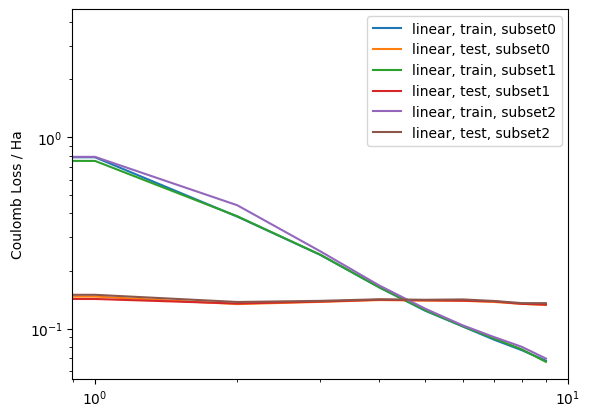

In [4]:
# Plot losses
fig, ax = plt.subplots(1, 1, sharey=True)
for subset in mean_train.keys():
    loss_train = mean_train[subset]
    loss_test = mean_test[subset]
    ax.loglog(loss_train, label=f"linear, train, subset{subset}")
    ax.loglog(loss_test, label=f"linear, test, subset{subset}")
ax.set_ylabel("Coulomb Loss / Ha")
ax.legend()

Next, plot the learning curve for the learning exercises.

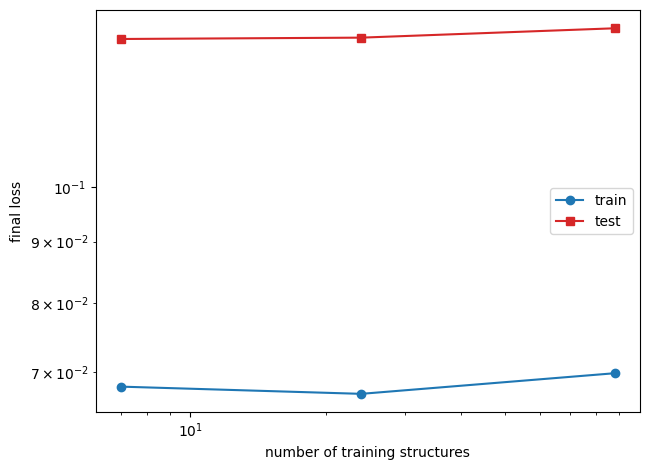

In [5]:
# Log-log learning curve plot of loss vs training set size
point = "final"  # take the final epoch loss, as opposed to "best" (i.e. lowest)
fig, ax = plots.learning_curve(
    [mean_train, mean_test],
    np.load(os.path.join(DATA_SETTINGS["data_dir"], "subset_sizes_train.npy")),
    point=point,
)

# Format
fig.tight_layout()
ax.set_ylabel(point + r" loss")
ax.legend(labels=["train", "test"])

# Save
plots.save_fig_mpltex(fig, os.path.join(plot_dir, "learning_curve"))

## Validation Structure

Now we can load the validation structure we created earlier, make a prediction
on it using our model.

Load the lambda-SOAP TensorMap for the validation structure and its QM (i.e. the
target) electron density. Then, load the best model and make a prediction on the
validation structure. 

In [6]:
# Load the lambda-SOAP TensorMaps for the input and output validation structure
in_val = io.load_tensormap_to_torch(
    os.path.join(DATA_SETTINGS["data_dir"], "in_val.npz"), **ML_SETTINGS["torch"]
)
out_val = equistore.load(os.path.join(DATA_SETTINGS["data_dir"], "out_val.npz"))

# Load the model from the largest training subset and latest epoch. In principle
# we could average the weights from multiple models from different exercises,
# but here we'll just load one.
model = io.load_torch_object(
    os.path.join(ML_SETTINGS["run_dir"], "exercise_0", "subset_2", "epoch_10", "model.pt"),
    device=ML_SETTINGS["torch"]["device"],
    torch_obj_str="model",
)

# Make a prediction on the validation structure (invariants standardized)
out_val_pred = model(in_val)

Plot a parity plot of the target electron density coefficients against
predicted, coloured by $\lambda$ value $\in [0, ..., 5]$

key not found for spherical_harmonics_l = 5 and {'species_center': 1}


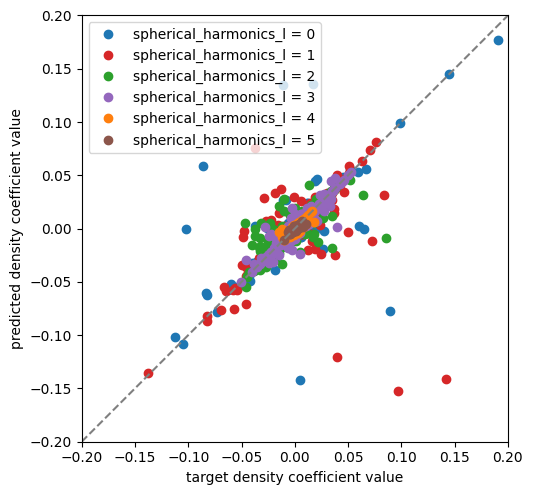

In [7]:
# Can also color by "species_center"
fig, ax = plots.parity_plot(
    target=utils.standardize_invariants(
        utils.tensor_to_numpy(out_val),
        equistore.load(
            os.path.join(
                DATA_SETTINGS["data_dir"], "exercise_0", "subset_2", "inv_means.npz"
            )
        ),
    ),
    predicted=utils.tensor_to_numpy(out_val_pred),
    color_by="spherical_harmonics_l",
)
lim = [-0.2, 0.2]
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect("equal")
ax.set_xlabel("target density coefficient value")
ax.set_ylabel("predicted density coefficient value")
ax.legend()

We can also colour the plot according to the elemental species, where index 1
indicates Hydrogen, 6 Carbon, 7 Nitrogen, 8 Oxygen, 16 Sulfur

## Visualization of the Electron Density

Having made a prediction on the validation structure using the linear model, we
can convert the TensorMap into a cube file format using Q-Stack, and visualize
the electron density.

First, build a molecule object using the Q-Stack ``compound`` module.

In [8]:
# Get the validation structure index from file
val_structure_idx = np.load(os.path.join(DATA_SETTINGS["data_dir"], "structure_idxs_val.npy"))[0][0]

# Load the xyz file of the validation structure
with open(os.path.join(DATA_SETTINGS["data_dir"], "molecule_list.dat"), "r") as molecule_list:
    val_xyz = molecule_list.read().splitlines()[val_structure_idx]

# Build a molecule object using Q-Stack. The basis used in density fitting for
# this particular dataset was 'ccpvqz jkfit'
molecule = qstack.compound.xyz_to_mol(
    os.path.join(DATA_SETTINGS["data_dir"], "xyz", val_xyz), basis="ccpvqz jkfit"
)

# Unstandardize the predicted density coefficients
out_val_pred = utils.standardize_invariants(
    utils.tensor_to_numpy(out_val_pred),
    equistore.load(os.path.join(DATA_SETTINGS["data_dir"], "exercise_0", "subset_2", "inv_means.npz")),
)

Do some renaming of TensorMaps to make naming conventions match and build a
delta electron density, given by subtraction of coefficients between the
predicted and target (i.e. QM) electron densities. This will help to visualize
areas of the molecule that the ML model isn't performing so well at performing.

In [9]:
# Rename tensors to fit Q-Stack naming convention
new_key_names = ["spherical_harmonics_l", "element"]
out_val = utils.rename_tensor(
    utils.drop_metadata_name(out_val, axis="samples", name="structure"), keys_names=new_key_names
)
out_val_pred = utils.rename_tensor(
    utils.drop_metadata_name(out_val_pred, axis="samples", name="structure"),
    keys_names=new_key_names,
)

# Generate a delta electron density: QM - ML. This helps to visualize where the
# ML model isn't working so well
out_val_delta = equistore.subtract(utils.tensor_to_numpy(out_val_pred), utils.tensor_to_numpy(out_val))

Vectorize the density coefficients and convert them to cube file format using Q-Stack

In [10]:
from qstack import equio
from qstack.fields import density2file

# Vectorize the coefficients from each of the TensorMaps
vect_coeffs_target = equio.tensormap_to_vector(molecule, out_val)
vect_coeffs_input = equio.tensormap_to_vector(molecule, out_val_pred)
vect_coeffs_delta = equio.tensormap_to_vector(molecule, out_val_delta)

# Define a number of grid points to represent the electon density on
n = 80

# Convert the basis function coefficients to a cube file
for (coeffs, filename) in [
    (vect_coeffs_target, "out_val.cube"),
    (vect_coeffs_input, "out_val_pred.cube"),
    (vect_coeffs_delta, "out_val_delta.cube"),
]:
    density2file.coeffs_to_cube(
        molecule,
        coeffs,
        os.path.join(plot_dir, filename),
        nx=n,
        ny=n,
        nz=n,
        resolution=None,
    )

Use Py3Dmol to visualize the cube files for the target, predicted, and delta
electron densities.

In [3]:
import py3Dmol

# Visualize the target density
for filename in ["out_val.cube", "out_val_pred.cube", "out_val_delta.cube"]:
    print(filename)
    v = py3Dmol.view(os.path.join(plot_dir, filename))
    v.setStyle({"stick": {}})
    v.addVolumetricData(
        open(os.path.join(plot_dir, filename), "r").read(),
        "cube",
        {"isoval": 0.01, "color": "blue", "opacity": 0.8},
    )
    v.show()

out_val.cube


NameError: name 'os' is not defined